<a href="https://colab.research.google.com/github/Elfeny7/ComputerVision_Learn/blob/main/HumanDetection_Yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Nov 21 02:37:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [4]:
%cd {HOME}
!git clone https://github.com/ultralytics/yolov5

%cd {HOME}/yolov5
!pip install -r requirements.txt

from IPython import display
display.clear_output()

In [5]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.9/78.2 GB disk)


In [6]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

from IPython import display
display.clear_output()

import detectron2
print("detectron2:", detectron2.__version__)

detectron2: 0.6


In [7]:
!pip install supervision==0.2.0

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.2.0


# **MAIN CODE**

In [8]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 86.9MB/s]


In [12]:
VIDEO_PATH = f"{HOME}/video.mp4"


0: 736x1280 44 persons, 1 backpack, 4 handbags, 1 tennis racket, 29.7ms
Speed: 16.3ms preprocess, 29.7ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


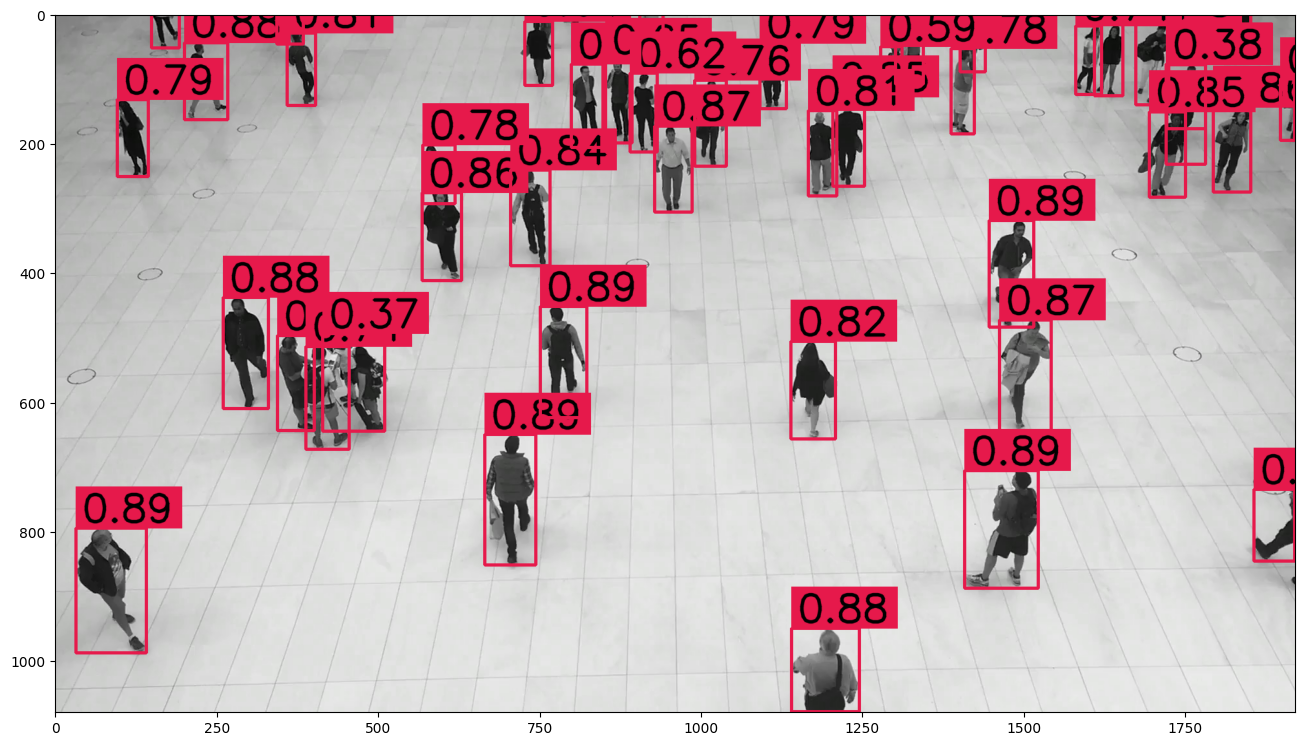

In [14]:
import supervision as sv
import numpy as np

#extrect video from frame
generator = sv.get_video_frames_generator(VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

#detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
#detect_only_person
detections = detections[detections.class_id == 0]

#annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16,16))

In [15]:
sv.VideoInfo.from_video_path(VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=25, total_frames=341)


0: 736x1280 44 persons, 1 backpack, 4 handbags, 1 tennis racket, 31.7ms
Speed: 7.6ms preprocess, 31.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


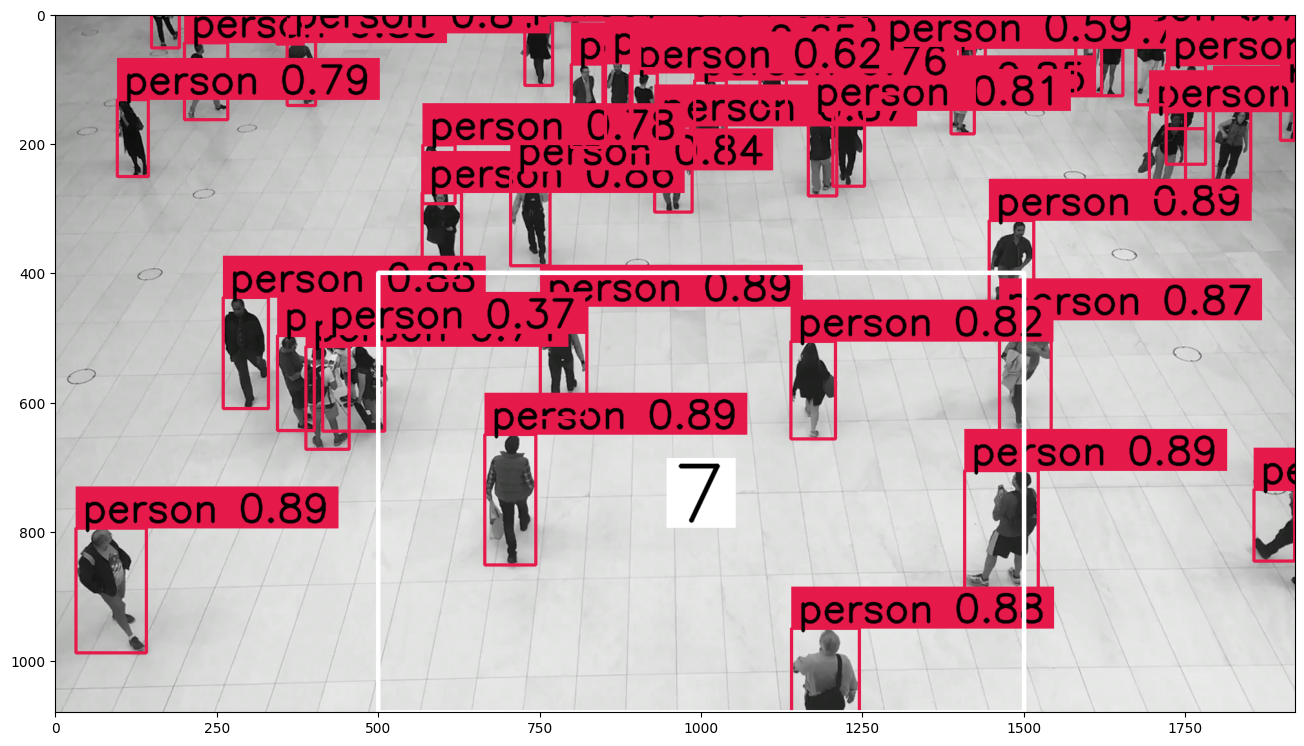

In [19]:
import supervision as sv
import numpy as np

# initiate polygon zone
polygon = np.array([
    [500, 400],
    [1500, 400],
    [1500, 1080],
    [500, 1080]
])
video_info = sv.VideoInfo.from_video_path(VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

#extrect video from frame
generator = sv.get_video_frames_generator(VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

#detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
#detect_only_person
detections = detections[detections.class_id == 0]
zone.trigger(detections=detections)

#annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16,16))

In [20]:
import supervision as sv
import numpy as np

# initiate polygon zone
polygon = np.array([
    [500, 400],
    [1500, 400],
    [1500, 1080],
    [500, 1080]
])
video_info = sv.VideoInfo.from_video_path(VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

def process_frame(frame: np.ndarray, _) -> np.ndarray:
  #detect
  results = model(frame, imgsz=1280)[0]
  detections = sv.Detections.from_yolov8(results)
  #detect_only_person
  detections = detections[detections.class_id == 0]
  zone.trigger(detections=detections)

  #annotate
  box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
  labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
  frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
  frame = zone_annotator.annotate(scene=frame)

  return frame

sv.process_video(source_path=VIDEO_PATH, target_path=f"{HOME}/video-result.mp4", callback=process_frame)

from IPython import display
display.clear_output()